Name: ___

Student ID: ___

Assessment: NLP Comparison

Dataset Origin: https://huggingface.co/datasets/ogozcelik/english-fake-news-detection

Generative AI (ChatGPT) was used for ideation and debugging only (planning code structure and resolving syntax issues). All analysis, implementation, and discussion are my own work.

# DATASET

This project uses the ogozcelik/english-fake-news-detection dataset from HuggingFace, containing approximately 5,284 short text samples labelled as True, False, or Other. The dataset frames a three-class fake-news classification problem based on social media tweets.

Detecting fake news in tweets requires understanding language to identify subtle cues that differentiate reliable information from fabricated or ambiguous statements. Thus, NLP is essential for a task like this.

A key characteristic of this dataset is its class imbalance. The largest category, Other, contains around 2800 samples, while False has about 1700 and True only  about 700. This uneven distribution significantly affects classifier performance, influencing decision boundaries and requiring careful evaluation to ensure models do not default to majority-class predictions. Additionally, the informal, conversational nature of the text makes preprocessing and robust embeddings necessary for effective downstream modelling.

The preprocessing workflow includes loading the dataset from HuggingFace, converting it into a pandas DataFrame, and conducting exploratory checks on class distribution. Columns were renamed for clarity, and string labels were mapped to numerical codes. Finally, a stratified train-test split (random_state=42) was applied to preserve label proportions across sets.

In [1]:
from datasets import load_dataset
import seaborn as sb
import matplotlib.pyplot as plt

ds = load_dataset("ogozcelik/english-fake-news-detection")

df = ds['train'].to_pandas()
df['label'].value_counts()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,count
label,
Other,2828
False,1729
True,727


In [ ]:
df.head()

,tweet,label
0,The U.N. refugee agency said Wednesday more th...,Other
1,"Zelensky: As a dictator, Putin wants to annex ...",Other
2,RT @rina__kor: “Zelensky fled to Poland and is...,False
3,The Nazis are on the run Westwards\nMARIUPOL h...,False
4,🇪🇺🇺🇦 European Commission President Ursula van ...,Other


In [2]:
from sklearn.model_selection import train_test_split

df['category'] = df['label'].map({"True":0, "False":1, "Other":2})

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['category'],
    random_state=42
)

In [3]:
train_df = train_df.rename(columns={"label": "tag"})
test_df = test_df.rename(columns={"label": "tag"})

train_df = train_df.rename(columns={"category": "label"})
test_df = test_df.rename(columns={"category": "label"})

train_df.head()

,tweet,tag,label
5159,Are you worried about losing your #Illinois #M...,Other,2
2526,"@Franklin_Graham @piersmorgan BS,Frankie. \n1s...",Other,2
3606,Omg. How crooked can they get. Wake up Democra...,False,1
3827,"If we take an annual average cost of 9,000 eur...",Other,2
810,Russia-Ukraine war: What happened today (April...,Other,2


# REPRESENTATION LEARNING

The project implements two distinct strategies for transforming raw tweets into numerical representations suitable for machine learning.

## Sentence-BERT (SBERT)
The first pathway uses Sentence-BERT (all-MiniLM-L6-v2), a lightweight 6-layer MiniLM model that generates 384-dimensional sentence embeddings. These embeddings are precomputed and remain frozen throughout training. Because SBERT captures contextual semantics at the sentence level, it performs well on short, noisy text while remaining efficient with resources.

After embedding, these fixed vectors are passed to classical machine-learning classifiers such as Logistic Regression and XGBoost.

In [ ]:
# encoding using sentenceBERT

X_train = train_df["tweet"].tolist()
X_test  = test_df["tweet"].tolist()

y_train = train_df["label"].tolist()
y_test  = test_df["label"].tolist()

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

X_train_emb = model.encode(X_train, convert_to_numpy=True)
X_test_emb  = model.encode(X_test, convert_to_numpy=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## DistilBERT

The second pathway relies on DistilBERT, which operates very differently. Instead of producing a static embedding, DistilBERT tokenizes each input and processes it through a transformer encoder that is fine-tuned during training.

The model updates its internal hidden states and weights using the classification loss, allowing it to learn task-specific features and adapt its language understanding (from the pre-training on general text data) to this fake-news dataset. This dynamic representation typically captures deeper linguistic cues, especially when subtle differences distinguish True, False, and Other labels.

Weighing these two pathways, SBERT provides fast, fixed semantic vectors, while DistilBERT offers an end-to-end trainable pipeline.

Together, these approaches demonstrate two complementary embedding philosophies: precomputed semantic encoding (static embedding) versus adaptive transformer-based representation learning (dynamic).

In [4]:
from datasets import Dataset
from transformers import AutoTokenizer

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def encode(batch):
    return tokenizer(
        batch['tweet'],
        truncation=True,
        padding='max_length',
        max_length=64
    )

train_ds = train_ds.map(encode, batched=True)
test_ds = test_ds.map(encode, batched=True)

train_ds = train_ds.with_format("torch")
test_ds = test_ds.with_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

# ALGORITHMS

This project evaluates three learning algorithms. Originally, the two pipelines for this task were SBERT+LR and DistilBERT. XGBoost was added as a constrasting classical model when LR delivered subpar results.

## Pipeline 1 - SBERT + Logistic Regression

Logistic Regression (LR) is used as the primary classifier for the fixed 384-dimensional SBERT embeddings. LR is a linear model that learns a set of weight vectors that best separate the three classes (True, False, Other) based on the semantic features encoded in the embeddings.

Because SBERT already captures contextual meaning and compresses each tweet into a dense semantic space, a simple linear boundary might be sufficient for classification.

There is risk bias toward the majority classes, so the model uses class_weight="balanced", ensuring that minority classes contribute proportionally to the loss function.

LR models linearly separable relationships in embedding space and provides a strong baseline for evaluating the impact of more complex algorithms. Its low computational cost also makes it ideal as the first pipeline for semantic-embedding-based classification.

In [ ]:
# train logistic regression

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(X_train_emb, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

pred = clf.predict(X_test_emb)

print("Sentence-BERT + LR Results\n")
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))


Sentence-BERT + LR Results

              precision    recall  f1-score   support

           0       0.49      0.75      0.59       145
           1       0.68      0.69      0.69       346
           2       0.83      0.71      0.77       566

    accuracy                           0.71      1057
   macro avg       0.67      0.72      0.68      1057
weighted avg       0.74      0.71      0.72      1057

Accuracy: 0.7095553453169348


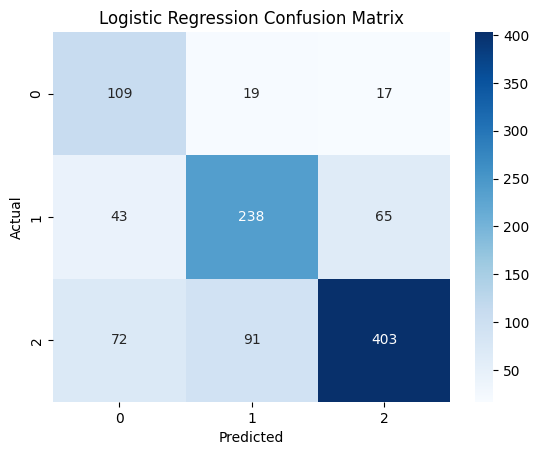

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# visualize the mistakes
cm = confusion_matrix(y_test, pred)
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Pipeline 1b - SBERT + XGBoost (multi-class softprob)

The secondary classical ML model is XGBoost, configured with the multi:softprob objective for multi-class classification. XGBoost is an ensemble of gradient-boosted decision trees, designed to capture non-linear relationships between features.

By training an ensemble of weak learners that loop to correct each other's errors, the model evaluates hundreds or thousands of decision boundaries in the SBERT embedding space.

This makes XGBoost an interesting contrast to Logistic Regression. LR assumes linear separability, while XGBoost can model complex, non-linear interactions across the 384 embedding dimensions.

This capability often yields better performance on imbalanced datasets, especially when certain classes depend on patterns that aren't linearly separable. XGBoost's regularization and shrinkage mechanisms also help control overfitting while exploiting the semantic richness of SBERT vectors.

In [ ]:
import xgboost as xgb

params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "scale_pos_weight": 1
}

dtrain = xgb.DMatrix(X_train_emb, label=y_train)
dtest  = xgb.DMatrix(X_test_emb, label=y_test)

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dtest, "test")],
    verbose_eval=20
)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:11:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	test-mlogloss:1.00192
[20]	test-mlogloss:0.70846
[40]	test-mlogloss:0.61430
[60]	test-mlogloss:0.57337
[80]	test-mlogloss:0.55552
[100]	test-mlogloss:0.54278
[120]	test-mlogloss:0.53423
[140]	test-mlogloss:0.53032
[160]	test-mlogloss:0.52976
[180]	test-mlogloss:0.52710
[199]	test-mlogloss:0.52440


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

probs = model.predict(dtest)
y_pred = np.argmax(probs, axis=1)

print("Sentence-BERT + XGBoost Results\n")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Sentence-BERT + XGBoost Results

              precision    recall  f1-score   support

           0       0.85      0.57      0.68       145
           1       0.82      0.69      0.75       346
           2       0.79      0.93      0.85       566

    accuracy                           0.80      1057
   macro avg       0.82      0.73      0.76      1057
weighted avg       0.81      0.80      0.79      1057

Accuracy: 0.8013245033112583
Confusion matrix:
 [[ 82  22  41]
 [  6 239 101]
 [  8  32 526]]


## Pipeline 2 - DistilBERT Fine-Tuning

The second main pipeline fine-tunes DistilBERT, a compressed version of BERT that retains most of BERT's performance while being faster and lighter. Unlike SBERT embeddings, DistilBERT does not rely on frozen representations. Instead, the transformer's internal weights are updated during training so that it learns features specific to this fake-news dataset.

The HuggingFace Trainer manages batching, optimization, and evaluation, while looping back across all transformer layers. This allows the model to adapt its token-level and sentence-level representations based on the classification gradients.

Fine-tuning often yields better performance than classical ML applied to fixed embeddings. The model updates its understanding of syntax, semantics, and subtle linguistic markers of misinformation.

However, fine-tuning has higher computational cost and a greater risk of overfitting, especially with a dataset of just over 5k samples. However, transformer-based models still outperform classical models where nuance matters.

In [6]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./fake_news_model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    report_to="none",
    num_train_epochs=3,
    weight_decay=0.01,
)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.782100,0.593494
2,0.483700,0.525833
3,0.306300,0.547341


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1587, training_loss=0.5104159623778836, metrics={'train_runtime': 4465.7033, 'train_samples_per_second': 2.84, 'train_steps_per_second': 0.355, 'total_flos': 209981129943168.0, 'train_loss': 0.5104159623778836, 'epoch': 3.0})

In [11]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

predictions = trainer.predict(test_ds)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

print("DistilBERT Classification Report:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))

DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       145
           1       0.79      0.79      0.79       346
           2       0.86      0.87      0.87       566

    accuracy                           0.82      1057
   macro avg       0.79      0.79      0.79      1057
weighted avg       0.82      0.82      0.82      1057

Accuracy: 0.8202459791863765


In [13]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[102  20  23]
 [ 19 272  55]
 [ 22  51 493]]


# EVALUATION

Model performance was assessed using an 80/20 stratified train-test split to preserve the dataset's class proportions. The evaluation included accuracy, precision, recall, F1-score, and confusion matrices, which are essential for interpreting results in a three-class setup with significant imbalance.

Because the dataset is skewed toward the Other class, accuracy alone would give an inflated view of performance; metrics like macro-averaged F1 offer a more reliable picture of how well each class is handled. Confusion matrices further reveal that the True class is consistently the hardest to classify, largely due to its low support, while Other is the easiest.

The SBERT + Logistic Regression pipeline shows solid performance on the majority classes but struggles with the minority True class. As a linear classifier, LR finds it difficult to capture subtle semantic differences, and imbalance amplifies this limitation. The SBERT + XGBoost model offers a slight improvement, benefiting from its ability to model non-linear relationships in the embedding space and producing more balanced class-wise results.

The DistilBERT fine-tuned model delivers the strongest overall performance. Its ability to learn task-specific language representations enables higher recall and F1 on the minority class.

Overall, deeper contextual models outperform shallow classifiers on semantic tasks like fake-news detection.